In [70]:
from typing import Union, List, Tuple
import os.path
import re

from tqdm import tqdm
import matplotlib.pyplot as plt

def filter_formulas(in_filename: str, out_filename: str, get: bool = False) -> Union[None, List[str]]:
    """
    Reads a file containing LaTeX formulas from 'in_filename' and removes all
    occurrences of the '\label{...}' substring from each formula. The resulting
    formulas are written to a new file named 'out_filename'. Each formula is
    separated by two newline characters.

    Parameters:
        in_filename : str
            The name of the input file containing LaTeX formulas.
        out_filename : str
            The name of the output file to write the filtered formulas.
        get : bool, optional
            If True, returns the list of filtered formulas in addition to writing
            them to a file. Defaults to False.

    Returns:
        None or list of str
            If get is False (default), the function writes the filtered formulas to a file
            and returns None. If get is True, the function returns a list of the filtered formulas.

    Raises:
        FileNotFoundError
            If the input file does not exist.
        IOError
            If the input file cannot be opened for reading, or the output file
            cannot be opened for writing.
    """

    if not os.path.isfile(in_filename):
        raise FileNotFoundError(f"File not found: {in_filename}")

    # Importing initial formulas
    with open(in_filename, 'r', encoding='ISO-8859-1') as f:
        formulas = [line.strip() for line in f.readlines()]

    # Define a regular expression pattern to match \label{...} substrings
    pattern = re.compile(r'(\\label\{.*?\}|%)')

    # Remove the \label{...} and % substring from each string in the 'formulas' list
    filtered_formulas = [pattern.sub('', s) for s in formulas]

    # Save the 'filtered' formulas in a file
    with open(out_filename, 'w') as f:
        for line in filtered_formulas:
            f.write(line+'\n \n')

    if get:
        return filtered_formulas


In [71]:
def to_inline_expr(math_expr: str) -> str:
    """
    Convert a LaTeX math expression to an inline math expression.

    Parameters
    ----------
    math_expr : str
        The LaTeX math expression to convert.

    Returns
    -------
    str
        The converted inline math expression.
    """
    return '$' + math_expr + '$'

In [72]:
def latex_to_image(math_expr: str, file_name: str, file_format: str = 'png',
                   picture_dims: Union[str,Tuple[float,float]] = 'A4',
                   resolution: Union[float, int] = 300, transparent: bool = True) -> None:
    """
    Converts a LaTeX math expression to an image in the specified file format and saves it with the specified file name.

    Args:
        math_expr (str): The LaTeX math expression to be converted to an image.
        file_name (str): The name of the file to be saved.
        file_format (str, optional): The format of the output file. Defaults to 'png'.
        picture_dims (Union[str,Tuple[float,float]], optional): The dimensions of the output picture. Can be either a
                                                               string specifying one of the standard dimensions (Letter,
                                                               Legal, A4, A5) or a tuple of the form (width, height).
                                                               Defaults to 'A4'.
        resolution (Union[float, int], optional): The resolution of the output image in DPI (dots per inch). Defaults to 300.
        transparent (bool, optional): Whether to save the image with a transparent background. Defaults to True.

    Raises:
        ValueError: If picture_dims is not one of the standard dimensions (Letter, Legal, A4, A5).
    """

    # Standard square dimensions of output picture
    std_dims = {"Letter":(8.5,14.0), "Legal":(8.5,14.0),
                "A4":(8.3,11.7), "A5":(5.8, 8.3)}

    if picture_dims in list(std_dims.keys()):
        DIMS = std_dims[picture_dims]
    else:
        raise ValueError(f"{picture_dims} not known - should be in: {list(std_dims.keys())}.")

    # Set the LaTeX font
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

    # Define the math expression as a string
    expr = to_inline_expr(math_expr=math_expr)

    # Add $ symbols to format the string as an inline math expression
    inline_expr = to_inline_expr(math_expr=math_expr)

    # Create a plot with the expression
    fig, ax = plt.subplots(figsize=DIMS)
    ax.text(0.5, 0.5, inline_expr, size=20, ha='center')

    # Remove the plot axes
    ax.set_axis_off()

    # Save the plot as a PNG with a transparent background
    fig.savefig(fname=file_name+"."+file_format, format=file_format, transparent=transparent, bbox_inches='tight', pad_inches=0.0, dpi=resolution)
    plt.close(fig)


  0%|          | 3/104564 [00:01<10:25:38,  2.79it/s]


KeyboardInterrupt: 

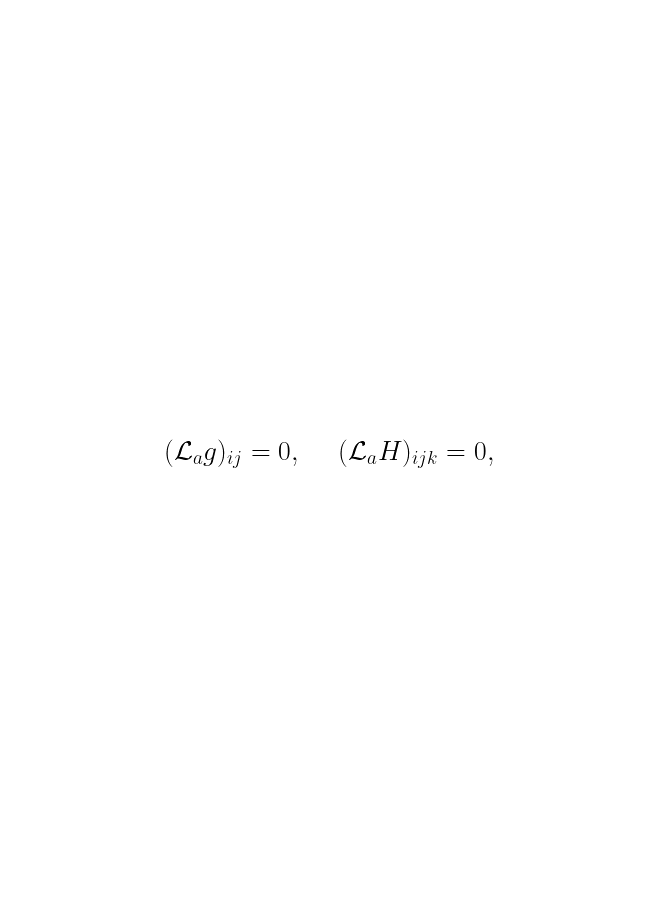

In [75]:
# Filtering equations for unwanted tokens and saving pictures in same order as equations
original_filename = 'Data/im2latex_formulas.lst'
new_filename = 'Data/im2latex_formulas.txt'
filtered_formulas = filter_formulas(in_filename=original_filename, out_filename=new_filename, get=True)

for line_nr in tqdm(range(len(filtered_formulas))):
    location = 'Data/im2latex_formulas_pictures/'
    filename = f'eq_{line_nr}'
    latex_to_image(math_expr=filtered_formulas[line_nr],file_name=location+filename)

In [76]:
from sympy import sympify, SympifyError

def is_valid_latex_math(expr_str):
    try:
        sympify(expr_str)
        return True
    except SympifyError:
        return False

In [79]:
is_valid_latex_math(to_inline_expr(a[1]))

False